In [4]:
import pandas as pd
import quandl
import datetime

In [23]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)
 
type(apple)

apple.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-04,102.61,105.368,102.00,105.35,67649387.0,0.0,1.0,99.136516,101.801154,98.547165,101.783763,67649387.0
2016-01-05,105.75,105.850,102.41,102.71,55790992.0,0.0,1.0,102.170223,102.266838,98.943286,99.233131,55790992.0
2016-01-06,100.56,102.370,99.87,100.70,68457388.0,0.0,1.0,97.155911,98.904640,96.489269,97.291172,68457388.0
2016-01-07,98.68,100.130,96.43,96.45,81094428.0,0.0,1.0,95.339552,96.740467,93.165717,93.185040,81094428.0
2016-01-08,98.55,99.110,96.76,96.96,70798016.0,0.0,1.0,95.213952,95.754996,93.484546,93.677776,70798016.0


Populating the interactive namespace from numpy and matplotlib


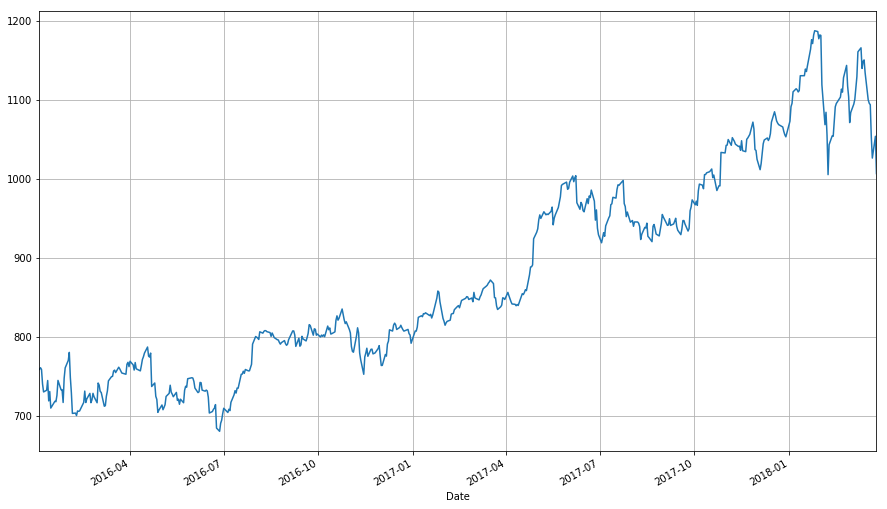

In [17]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj. Close"].plot(grid = True) # Plot the adjusted closing price of AAPL


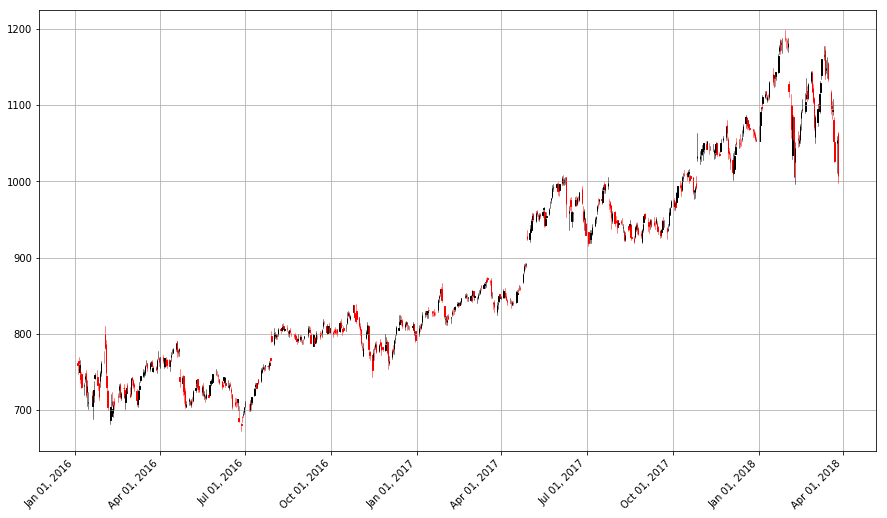

In [19]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple, adj=True, stick="day")

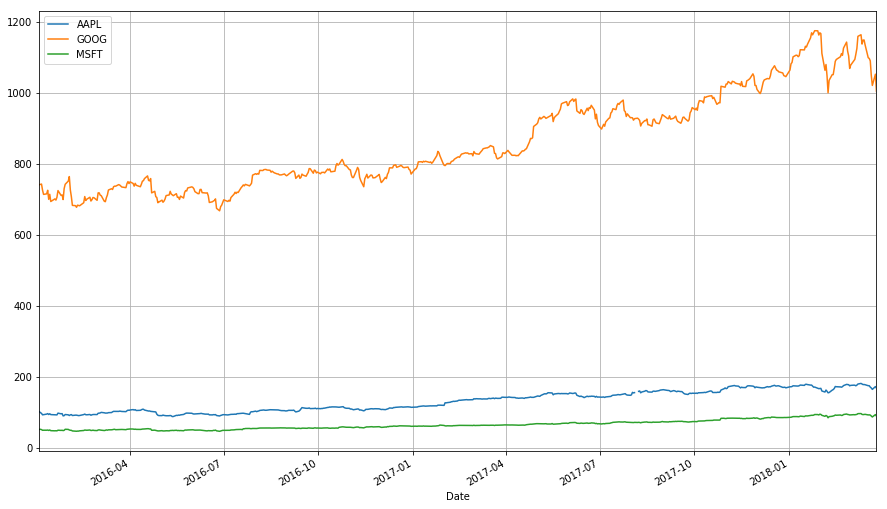

In [24]:
microsoft, google = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["MSFT", "GOOG"])
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                      "MSFT": microsoft["Adj. Close"],
                      "GOOG": google["Adj. Close"]})
 
stocks.head()
stocks.plot(grid = True)

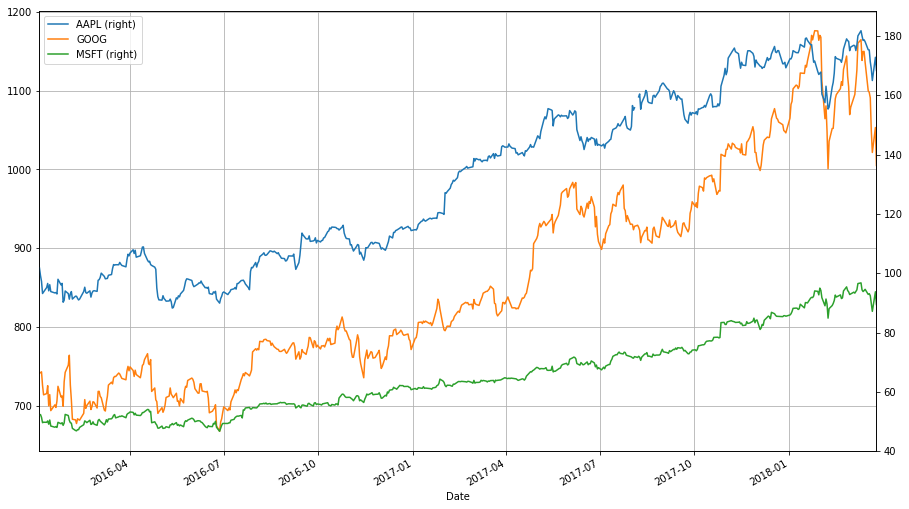

In [25]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)


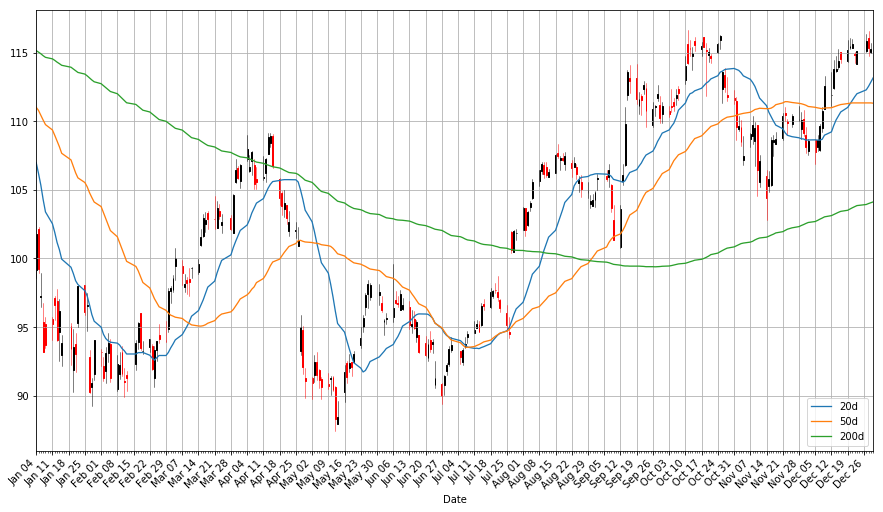

In [31]:
start = datetime.datetime(2010,1,1)
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
apple["50d"] = np.round(apple["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Adj. Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)


In [32]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,200d,20d-50d
Date,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,162.68,4.37
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,162.75,4.30
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,162.81,3.96
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,162.91,3.70
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,162.98,3.36


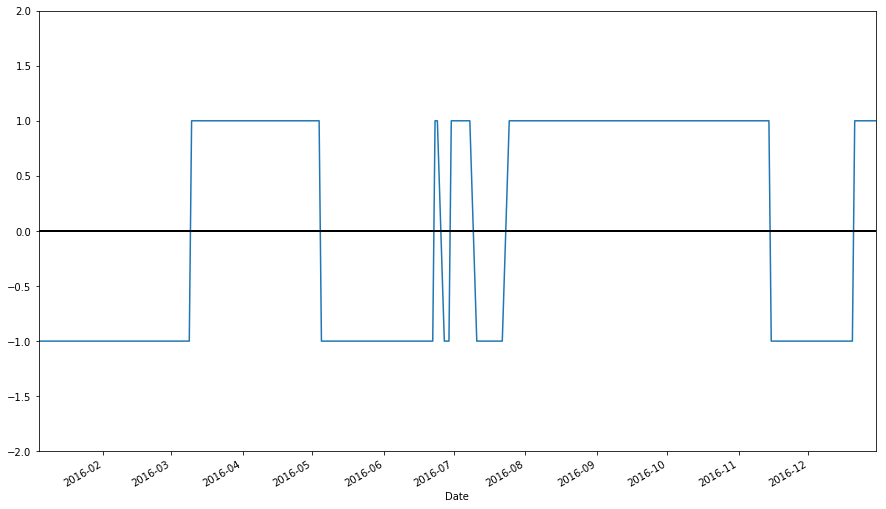

In [36]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-04':'2016-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)



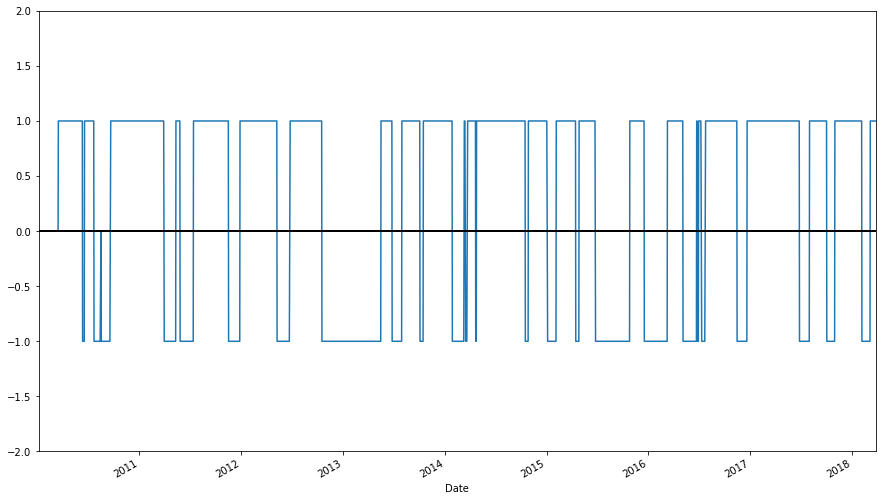

In [35]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)


In [37]:
apple["Regime"].value_counts()

 1    1323
-1     694
 0      53
Name: Regime, dtype: int64

In [38]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.loc[:, "Regime"].iloc[-1]
apple.loc[:, "Regime"].iloc[-1] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.loc[:, "Regime"].iloc[-1] = regime_orig
apple.tail()

/home/pi/.venv/jns/lib/python3.5/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/pi/.venv/jns/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sign
  after removing the cwd from sys.path.


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0,176.94,172.57,162.68,4.37,1,0.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0,176.76,172.46,162.75,4.30,1,0.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0,176.23,172.27,162.81,3.96,1,0.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0,175.92,172.22,162.91,3.70,1,0.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0,175.41,172.05,162.98,3.36,1,-1.0


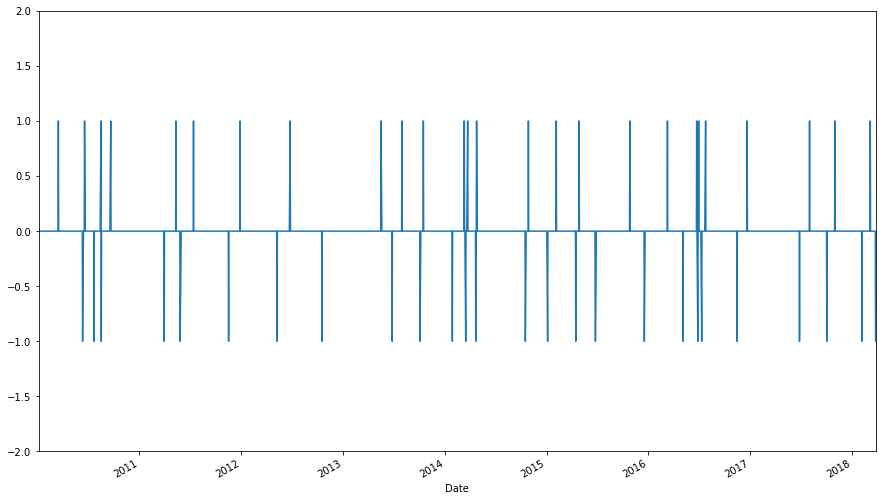

In [39]:
apple["Signal"].plot(ylim = (-2, 2))

In [40]:
apple["Signal"].value_counts()

 0.0    2014
-1.0      28
 1.0      27
Name: Signal, dtype: int64

In [41]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2010-03-16    224.450
2010-06-18    274.074
2010-08-16    247.640
2010-09-20    283.230
2011-05-12    346.570
2011-07-14    357.770
2011-12-28    402.640
2012-06-25    570.765
2013-05-17    433.260
2013-07-31    452.530
2013-10-16    501.114
2014-03-11    536.090
2014-03-12    536.610
2014-03-24    539.190
2014-04-25    571.940
2014-10-28    106.740
2015-02-05    119.940
2015-04-28    130.560
2015-10-27    114.550
2016-03-10    101.170
2016-06-23     96.100
2016-06-30     95.600
2016-07-25     97.340
2016-12-21    117.060
2017-08-02    157.140
2017-11-01    166.890
2018-03-08    176.940
Name: Close, dtype: float64

In [42]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-16,28.844953,1,Buy
2010-06-11,32.579568,-1,Sell
2010-06-18,35.222329,1,Buy
2010-07-22,33.288194,-1,Sell
2010-08-16,31.825192,0,Buy
2010-08-17,32.381657,-1,Sell
2010-09-20,36.399003,1,Buy
2011-03-30,44.803814,0,Sell
2011-03-31,44.788071,-1,Sell


In [43]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-11,28.844953,3.734615
2010-06-18,2010-07-22,35.222329,-1.934135
2010-09-20,2011-03-30,36.399003,8.404812
2011-05-12,2011-05-27,44.539075,-1.177188
2011-07-14,2011-11-17,45.978431,2.524014
2011-12-28,2012-05-09,51.744852,21.402711
2012-06-25,2012-10-17,73.351258,9.844240
2013-05-17,2013-06-26,56.878472,-4.619751
2013-07-31,2013-10-04,59.408242,4.423577


In [45]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_long_profits.index,
                            "End": apple_long_profits["End Date"]})
apple_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
apple_long_profits

,End Date,Price,Profit,Low
Date,,,,
2010-03-16,2010-06-11,28.844953,3.734615,25.606402
2010-06-18,2010-07-22,35.222329,-1.934135,30.791939
2010-09-20,2011-03-30,36.399003,8.404812,35.341333
2011-05-12,2011-05-27,44.539075,-1.177188,42.335061
2011-07-14,2011-11-17,45.978431,2.524014,45.367990
2011-12-28,2012-05-09,51.744852,21.402711,51.471117
2012-06-25,2012-10-17,73.351258,9.844240,72.688768
2013-05-17,2013-06-26,56.878472,-4.619751,51.942335
2013-07-31,2013-10-04,59.408242,4.423577,59.001273


In [46]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(Bpd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2010-03-16,2010-06-11,1.012698e+06,3.734615,28.844953,3400.0,1.000000e+06,0.0,12697.691096,98072.841239
2010-06-18,2010-07-22,1.007282e+06,-1.934135,35.222329,2800.0,1.012698e+06,0.0,-5415.577333,98622.521053
2010-09-20,2011-03-30,1.029975e+06,8.404812,36.399003,2700.0,1.007282e+06,0.0,22692.991110,98277.306914
2011-05-12,2011-05-27,1.027268e+06,-1.177188,44.539075,2300.0,1.029975e+06,0.0,-2707.531638,102439.873355
2011-07-14,2011-11-17,1.032820e+06,2.524014,45.978431,2200.0,1.027268e+06,0.0,5552.830218,101152.549241
2011-12-28,2012-05-09,1.073486e+06,21.402711,51.744852,1900.0,1.032820e+06,0.0,40665.151235,98315.218526
2012-06-25,2012-10-17,1.087267e+06,9.844240,73.351258,1400.0,1.073486e+06,0.0,13781.935982,102691.760672
2013-05-17,2013-06-26,1.078490e+06,-4.619751,56.878472,1900.0,1.087267e+06,0.0,-8777.527400,108069.096937
2013-07-31,2013-10-04,1.086452e+06,4.423577,59.408242,1800.0,1.078490e+06,0.0,7962.438409,106934.835757
2013-10-16,2014-01-28,1.088218e+06,1.103650,66.221597,1600.0,1.086452e+06,0.0,1765.839598,105954.555657


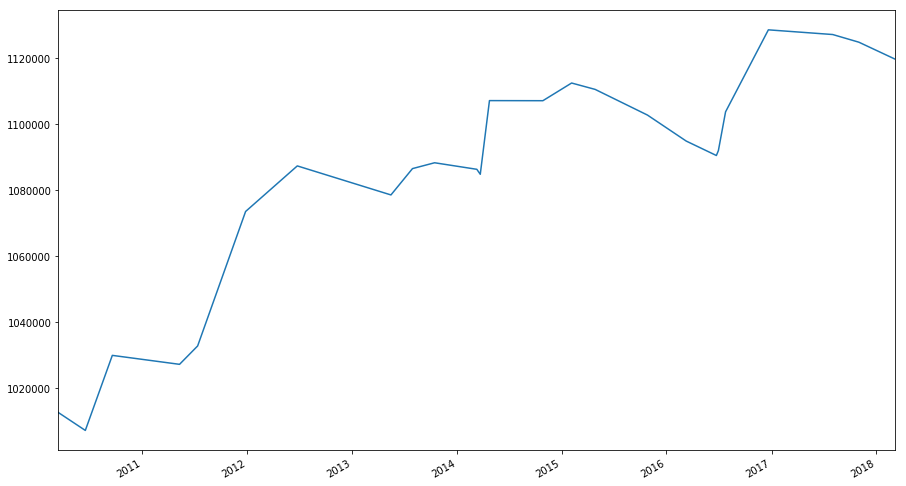

In [47]:
apple_backtest["End Port. Value"].plot()

In [48]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].loc[:, "Regime"].iloc[-1]
        s[1].loc[:, "Regime"].iloc[-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].loc[:, "Regime"].iloc[-1] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results
 
# Get more stocks
(microsoft, google, facebook, twitter, netflix,
amazon, yahoo, ge, qualcomm, ibm, hp) = (quandl.get("WIKI/" + s, start_date=start,
                                                                         end_date=end) for s in ["MSFT", "GOOG", "FB", "TWTR",
                                                                                                 "NFLX", "AMZN", "YHOO", "GE",
                                                                                                 "QCOM", "IBM", "HPQ"])

In [49]:
signals = ma_crossover_orders([("AAPL", apple),
                              ("MSFT",  microsoft),
                              ("GOOG",  google),
                              ("FB",    facebook),
                              ("TWTR",  twitter),
                              ("NFLX",  netflix),
                              ("AMZN",  amazon),
                              ("YHOO",  yahoo),
                              ("GE",    ge),
                              ("QCOM",  qualcomm),
                              ("IBM",   ibm),
                              ("HPQ",   hp)],
                            fast = 20, slow = 50)
signals

/home/pi/.venv/jns/lib/python3.5/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/pi/.venv/jns/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sign


Price  Regime Signal
Date       Symbol                            
2010-03-16 AAPL      28.844953     1.0    Buy
           AMZN     131.790000     1.0    Buy
           GE        14.129260     1.0    Buy
           HPQ       19.921951     1.0    Buy
           IBM      105.460506     1.0    Buy
           MSFT      23.978839    -1.0   Sell
           NFLX      10.090000     1.0    Buy
           QCOM      32.235226    -1.0   Sell
           YHOO      16.360000    -1.0   Sell
2010-03-17 YHOO      16.500000     1.0    Buy
2010-03-24 MSFT      24.207442     1.0    Buy
2010-04-01 QCOM      34.929069     1.0    Buy
2010-05-07 QCOM      30.161131    -1.0   Sell
2010-05-10 HPQ       18.684203    -1.0   Sell
2010-05-17 YHOO      16.270000    -1.0   Sell
2010-05-19 AMZN     124.590000    -1.0   Sell
           GE        13.495907    -1.0   Sell
           MSFT      23.161072    -1.0   Sell
2010-05-20 IBM      102.001194    -1.0   Sell
2010-06-11 AAPL      32.579568    -1.0   Sell
2010-06-18 AAPL      35.222329     1.0    Buy
2010-06-29 IBM      103.064049     1.0    Buy
2010-06-30 IBM      101.737540    -1.0   Sell
2010-07-07 IBM      104.637735     1.0    Buy
2010-07-20 IBM      104.266971    -1.0   Sell
2010-07-22 AAPL      33.288194    -1.0   Sell
2010-07-27 QCOM      32.585294     1.0    Buy
2010-07-28 IBM      105.815940     1.0    Buy
2010-07-29 NFLX      14.002857    -1.0   Sell
2010-08-02 HPQ       18.129988     1.0    Buy
...                        ...     ...    ...
2017-11-01 AAPL     166.890000     1.0    Buy
2017-12-06 NFLX     185.300000    -1.0   Sell
2017-12-15 HPQ       20.920000    -1.0   Sell
2017-12-26 FB       175.990000    -1.0   Sell
2018-01-03 FB       184.670000     1.0    Buy
2018-01-09 NFLX     209.310000     1.0    Buy
2018-01-11 HPQ       22.410000     1.0    Buy
2018-01-18 QCOM      68.050000    -1.0   Sell
2018-01-19 QCOM      68.040000     1.0    Buy
2018-02-06 AAPL     163.030000    -1.0   Sell
2018-02-21 IBM      153.960000    -1.0   Sell
           QCOM      63.400000    -1.0   Sell
2018-02-22 HPQ       21.390000    -1.0   Sell
2018-02-23 FB       183.290000    -1.0   Sell
2018-02-27 GOOG    1118.290000    -1.0   Sell
2018-03-08 AAPL     176.940000     1.0    Buy
2018-03-09 HPQ       24.650000     1.0    Buy
2018-03-14 GOOG    1149.490000     1.0    Buy
2018-03-23 GOOG    1021.570000    -1.0   Sell
2018-03-27 AAPL     168.340000     1.0   Sell
           AMZN    1497.050000     1.0   Sell
           FB       152.190000    -1.0    Buy
           GE        13.440000    -1.0    Buy
           GOOG    1005.100000    -1.0    Buy
           HPQ       21.770000     1.0   Sell
           IBM      151.910000    -1.0    Buy
           MSFT      89.470000     1.0   Sell
           NFLX     300.690000     1.0   Sell
           QCOM      54.840000    -1.0    Buy
           TWTR      28.070000     1.0   Sell

[509 rows x 3 columns]

In [50]:
bk = backtest(signals, 1000000)
bk

End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                    
2010-03-16 AAPL    9.019272e+05     1.000000e+06          0.000000   
           AMZN    8.096742e+05     1.000000e+06          0.000000   
           GE      7.107693e+05     1.000000e+06          0.000000   
           HPQ     6.111596e+05     1.000000e+06          0.000000   
           IBM     5.162451e+05     1.000000e+06          0.000000   
           MSFT    5.162451e+05     1.000000e+06          0.000000   
           NFLX    4.163541e+05     1.000000e+06          0.000000   
           QCOM    4.163541e+05     1.000000e+06          0.000000   
           YHOO    4.163541e+05     1.000000e+06          0.000000   
2010-03-17 YHOO    3.173541e+05     1.000000e+06          0.000000   
2010-03-24 MSFT    2.181036e+05     1.000000e+06          0.000000   
2010-04-01 QCOM    1.203022e+05     1.000000e+06          0.000000   
2010-05-07 QCOM    2.047534e+05     9.866498e+05         -4.767938   
2010-05-10 HPQ     2.981744e+05     9.804610e+05         -1.237749   
2010-05-17 YHOO    3.957944e+05     9.790810e+05         -0.230000   
2010-05-19 AMZN    4.830074e+05     9.740410e+05         -7.200000   
           GE      5.774787e+05     9.696076e+05         -0.633354   
           MSFT    6.724391e+05     9.653174e+05         -1.046370   
2010-05-20 IBM     7.642402e+05     9.622041e+05         -3.459312   
2010-06-11 AAPL    8.750107e+05     9.749017e+05          3.734615   
2010-06-18 AAPL    7.799105e+05     9.749017e+05          0.000000   
2010-06-29 IBM     6.871528e+05     9.749017e+05          0.000000   
2010-06-30 IBM     7.787166e+05     9.737079e+05         -1.326510   
2010-07-07 IBM     6.845426e+05     9.737079e+05          0.000000   
2010-07-20 IBM     7.783829e+05     9.733742e+05         -0.370764   
2010-07-22 AAPL    8.682610e+05     9.681520e+05         -1.934135   
2010-07-27 QCOM    7.737637e+05     9.681520e+05          0.000000   
2010-07-28 IBM     6.785293e+05     9.681520e+05          0.000000   
2010-07-29 NFLX    8.171576e+05     1.006889e+06          3.912857   
2010-08-02 HPQ     7.174427e+05     1.006889e+06          0.000000   
...                         ...              ...               ...   
2017-11-01 AAPL    1.297792e+05     2.153164e+06          0.000000   
2017-12-06 NFLX    3.336092e+05     2.149600e+06         -3.240000   
2017-12-15 HPQ     5.700052e+05     2.170395e+06          1.840267   
2017-12-26 FB      8.339902e+05     2.244450e+06         49.370000   
2018-01-03 FB      6.123862e+05     2.244450e+06          0.000000   
2018-01-09 NFLX    4.030762e+05     2.244450e+06          0.000000   
2018-01-11 HPQ     1.789762e+05     2.244450e+06          0.000000   
2018-01-18 QCOM    4.511762e+05     2.301960e+06         14.377402   
2018-01-19 QCOM    2.266442e+05     2.301960e+06          0.000000   
2018-02-06 AAPL    4.222802e+05     2.297328e+06         -3.860000   
2018-02-21 IBM     6.378242e+05     2.309716e+06          8.848221   
           QCOM    8.470442e+05     2.294404e+06         -4.640000   
2018-02-22 HPQ     1.060944e+06     2.284204e+06         -1.020000   
2018-02-23 FB      1.280892e+06     2.282548e+06         -1.380000   
2018-02-27 GOOG    1.504550e+06     2.316306e+06        168.790000   
2018-03-08 AAPL    1.274528e+06     2.316306e+06          0.000000   
2018-03-09 HPQ     1.045283e+06     2.316306e+06          0.000000   
2018-03-14 GOOG    8.153852e+05     2.316306e+06          0.000000   
2018-03-23 GOOG    1.019699e+06     2.290722e+06       -127.920000   
2018-03-27 AAPL    1.238541e+06     2.279542e+06         -8.600000   
           AMZN    1.537951e+06     2.377684e+06        490.710000   
           FB      1.537951e+06     2.377684e+06        -32.480000   
           GE      1.537951e+06     2.377684e+06        -16.213194   
           GOOG    1.537951e+06     2.377684e+06       -144.390000   
           HPQ     1.740412e+06  

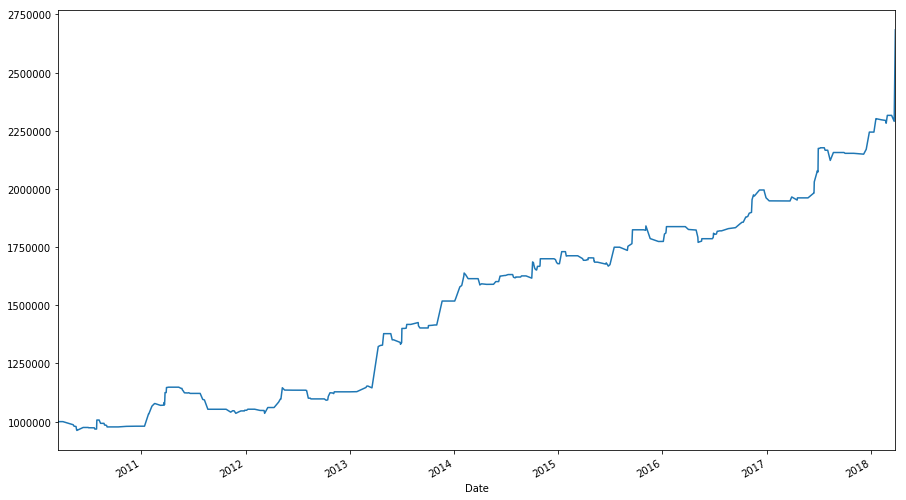

In [51]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

In [52]:
#spyder = web.DataReader("SPY", "yahoo", start, end)
spyder = spyderdat.loc[start:end]
spyder.iloc[[0,-1],:]

NameError: name 'spyderdat' is not defined